# 1. Prepare model path

## Load Clip model

In [ ]:
import sys
import os
import torch  
# Add Long-CLIP directory to path to import model module
# Get project root directory (assuming notebook is in Influence_indicator folder)
current_dir = os.getcwd()
if 'Influence_indicator' in current_dir:
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir
longclip_dir = os.path.join(project_root, "Long-CLIP")
if longclip_dir not in sys.path:
    sys.path.insert(0, longclip_dir)
    
from model import longclip
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = os.path.join(project_root, "Long-CLIP", "longclip-B.pt")
clip_model, clip_preprocess = longclip.load(model_path, device=device)
clip_model.eval()
1

1

In [ ]:
import os
# Get project root directory (assuming notebook is in Influence_indicator folder)
current_dir = os.getcwd()
if 'Influence_indicator' in current_dir:
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir
base_path = os.path.join(project_root, 'Data')

## Load pijc predictor

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import random
from itertools import combinations,permutations
import time
import json

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.in_user_feature = data['in_user_feature']
        self.out_user_feature = data['out_user_feature']
        self.message_feature = data['message_feature']
        self.y = data['y']

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.in_user_feature[idx], self.out_user_feature[idx], self.message_feature[idx], self.y[idx])

# Model definition
class MultiInputNet(nn.Module):
    def __init__(self, input_dim=512, num_classes=2, mean=None, std=None):
        super(MultiInputNet, self).__init__()

        self.mean = nn.Parameter(mean, requires_grad=False)
        self.std = nn.Parameter(std, requires_grad=False)
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def normalize(self, x, mean, std):
        mean = mean.to(x.device)
        std = std.to(x.device)
        return (x - mean) / std

    def forward(self, a1, a2, c):
        a1 = self.normalize(a1, self.mean[0], self.std[0])
        a2 = self.normalize(a2, self.mean[1], self.std[1])
        c = self.normalize(c, self.mean[2], self.std[2])
        a1_features = self.feature_extractor(a1)
        a2_features = self.feature_extractor(a2)
        c_features = self.feature_extractor(c)
        combined_features = torch.cat((a1_features, a2_features, c_features), dim=1)
        output = self.classifier(combined_features)
        return output

pijc_predictor_ckpt_path = f"{base_path}/model/model_epoch_100.pth"
model = MultiInputNet(input_dim=512, num_classes=2,mean = torch.zeros(3,512),std = torch.zeros(3,512)).to(device)

state_dict = torch.load(pijc_predictor_ckpt_path)
model.load_state_dict(state_dict)
model.eval()

MultiInputNet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
)

# 2. Load preliminary data (features, tweet_id, audience groups)

In [ ]:
### Test set
import json
tweet_user_mapping_path = f"{base_path}/text_split/tweet_user_mapping_test.json"
with open(tweet_user_mapping_path, 'r') as f:
    tweet_user_mapping = json.load(f)

In [ ]:
user_features_dict = torch.load(f"{base_path}/features/user_features_dict.pt")

In [6]:
def get_user_features(user_id):
    feature = user_features_dict.get(user_id)
    return feature if feature is not None else torch.zeros(512, dtype=torch.float32)

In [ ]:
msg_features_dict = torch.load(f"{base_path}/features/msg_features_dict.pt")
def get_msg_features(msg_id):
    feature = msg_features_dict.get(msg_id)
    return feature if feature is not None else torch.zeros(512, dtype=torch.float32)

In [ ]:
## Test
tweet_id = '1599341491792785413'#"1429151968342122500"
feature_1 = get_msg_features(tweet_id)
# feature_stepps = get_stepps_features(tweet_id)
print(f"message {tweet_id}:",feature_1)
# print(f"message_stepps {tweet_id}:",feature_stepps)

message 1599341491792785413: tensor([ 3.3765e-01,  1.0956e-01,  3.5492e-02, -6.8359e-02, -2.1497e-01,
        -1.6162e-01, -2.7002e-01, -3.3447e-01, -3.4937e-01,  1.7542e-01,
        -8.3984e-02,  1.9824e-01, -1.9763e-01, -2.1704e-01, -6.4819e-02,
        -7.7705e-03, -2.0801e-01, -2.1191e-01,  3.9746e-01,  5.2490e-01,
         5.1611e-01,  7.6904e-02,  9.1370e-02,  1.8539e-02, -2.0027e-03,
        -2.6953e-01, -6.9580e-02, -5.1172e-01,  2.3010e-01, -2.5610e-01,
         8.3252e-02, -1.0028e-01,  4.2163e-01,  2.0508e-01, -3.1396e-01,
         6.6986e-03, -1.1414e-01, -6.9641e-02, -3.5522e-01,  3.5986e-01,
         2.1863e-01, -2.9617e-02,  1.1420e-01,  2.9199e-01,  1.0107e-01,
        -4.9463e-01, -1.2317e-01,  1.7493e-01,  1.1023e-01,  1.7725e-01,
         3.9087e-01,  1.6003e-01, -1.0333e-01, -1.7944e-01, -1.0004e-01,
         1.2158e-01, -2.0493e-02, -4.4983e-02, -1.6492e-01,  3.0981e-01,
        -8.1665e-02,  3.9215e-02, -2.4695e-01, -6.4880e-02, -2.1509e-01,
        -5.4169e-03, -

In [9]:
user_id = '339794946'#"808470089234157568"
feature_2 = get_user_features(user_id)
print(f"user {user_id}:",feature_2)

user 339794946: tensor([ 1.7749e-01,  9.5215e-03, -2.3767e-01,  4.6112e-02, -8.2581e-02,
        -2.7686e-01, -1.9577e-02, -5.3125e-01,  1.0071e-01, -4.4708e-02,
         2.0276e-01,  3.2056e-01, -2.6025e-01, -3.9990e-01,  1.1151e-01,
        -1.4862e-02, -2.3425e-01,  8.7830e-02, -1.0431e-01,  1.9434e-01,
         5.8167e-02, -2.1704e-01,  2.0801e-01, -1.2500e-01,  1.5671e-02,
         2.9102e-01,  3.4448e-01, -1.2524e-01, -4.4830e-02, -9.3506e-02,
        -4.1577e-01, -2.2253e-01,  3.1714e-01,  2.1973e-01, -2.8345e-01,
        -1.8250e-01,  1.0468e-01, -3.4912e-01,  5.1117e-02,  4.4604e-01,
         2.7222e-01,  1.7200e-01,  6.5247e-02,  3.3496e-01, -1.4319e-01,
         6.2332e-03,  3.2623e-02, -1.0368e-02,  2.0459e-01,  3.0981e-01,
        -1.4893e-01,  2.2021e-01,  3.6646e-01,  9.8389e-02,  1.4355e-01,
        -1.6675e-01, -2.5513e-01, -2.0435e-01, -9.6313e-02, -1.1597e-01,
        -5.1636e-02, -1.1395e-01, -4.3579e-02, -2.3462e-01,  5.3833e-02,
        -1.0095e-01, -1.7407e-01,  

# 3. Evaluation

In [ ]:
import numpy as np
import torch
from itertools import permutations
import random
from tqdm import tqdm


def set_seed(seed=42):
    random.seed(seed)                # Python random
    np.random.seed(seed)             # NumPy random
    torch.manual_seed(seed)          # PyTorch CPU random
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)            # PyTorch GPU random
        torch.cuda.manual_seed_all(seed)        # For multi-GPU usage
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

def calculate_pijc_matrix(tweet_id, user_group, model_type='clip', max_users=200):
    user_ids = [uid.strip() for uid in user_group.split(',')]
    if len(user_ids) < 2:
        return np.zeros((len(user_ids), len(user_ids)))

    if len(user_ids) > max_users:
        user_ids = random.sample(user_ids, max_users)

    user_index = {uid: idx for idx, uid in enumerate(user_ids)}
    n = len(user_ids)
    pijc_matrix = np.zeros((n, n))

    msg_features = get_msg_features(tweet_id)
    if msg_features is None:
        return pijc_matrix
    msg_tensor = torch.FloatTensor(msg_features).unsqueeze(0).to(device)

    # Cache all user tensors
    user_tensor_cache = {}
    for uid in user_ids:
        feats = user_features_dict.get(uid)
        if feats is not None:
            user_tensor_cache[uid] = torch.FloatTensor(feats).unsqueeze(0).to(device)

    # Construct all valid user pairs
    pairs = [(u1, u2) for u1, u2 in permutations(user_ids, 2)
             if u1 in user_tensor_cache and u2 in user_tensor_cache]

    if not pairs:
        return pijc_matrix

    u1_batch = torch.cat([user_tensor_cache[u1] for (u1, u2) in pairs], dim=0)
    u2_batch = torch.cat([user_tensor_cache[u2] for (u1, u2) in pairs], dim=0)
    msg_batch = msg_tensor.repeat(len(pairs), 1)

    with torch.no_grad():
        outputs = model(u1_batch, u2_batch, msg_batch)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

    # Fill matrix
    for (u1, u2), p in zip(pairs, probs):
        i = user_index[u1]
        j = user_index[u2]
        pijc_matrix[i][j] = p

    return pijc_matrix


# ================== Main computation and saving logic ==================

import os
import json
from collections import defaultdict

# ========== Settings ==========
model_type = 'clip'
output_base_dir = os.path.join(base_path, "Evaluation", "pijc_matrix_500all")
os.makedirs(output_base_dir, exist_ok=True)

# ========== Sample a subset of tweets ==========
all_tweet_ids = list(tweet_user_mapping.keys())
# Filter tweets with more than 1 user
filtered_tweet_ids = []
for tid, users in tweet_user_mapping.items():
    user_list = [u.strip() for u in users.split(',')] if isinstance(users, str) else list(users)
    if len(user_list) > 1:
        filtered_tweet_ids.append(tid)

print(f"Original tweet count: {len(tweet_user_mapping)}, tweets with > 1 user: {len(filtered_tweet_ids)}")
sample_size = 500  # Can be modified as needed
sampled_tweet_ids = random.sample(all_tweet_ids, sample_size)

# ========== Count total users ==========
unique_users = set()
for tid in sampled_tweet_ids:
    group_str = tweet_user_mapping[tid]
    users = [u.strip() for u in group_str.split(',')]
    unique_users.update(users)

print(f"\nUsing model [{model_type}], sampled {sample_size} tweets")
print(f"Total unique users: {len(unique_users)}")

# ========== Run model ==========
for idx, current_tweet_id in enumerate(tqdm(sampled_tweet_ids, desc="Processing tweets", unit="tweet")):
    result_dict = dict()

    correct_group_str = tweet_user_mapping[current_tweet_id]
    correct_user_list = [u.strip() for u in correct_group_str.split(',')]
    correct_user_set = set(correct_user_list)

    correct_matrix = calculate_pijc_matrix(current_tweet_id, correct_group_str, model_type)
    result_dict["correct_group"] = correct_matrix.tolist()

    other_user_set = set()
    for other_tid in sampled_tweet_ids:
        if other_tid == current_tweet_id:
            continue
        for user in tweet_user_mapping[other_tid].split(','):
            u = user.strip()
            if u not in correct_user_set:
                other_user_set.add(u)

    if len(other_user_set) < 2:
        print(f"[Skip] {current_tweet_id} has insufficient users in other_group")
        continue

    other_user_list = list(other_user_set)
    other_group_str = ','.join(other_user_list)
    other_matrix = calculate_pijc_matrix(current_tweet_id, other_group_str, model_type)
    result_dict["other_group"] = other_matrix.tolist()

    save_path = os.path.join(output_base_dir, f"pijc_matrix_{current_tweet_id}.json")
    with open(save_path, 'w') as f:
        json.dump(result_dict, f, indent=2)

    if idx % 10 == 0:
        print(f"[{model_type}] Completed {idx+1}/{len(sampled_tweet_ids)} → {save_path}")

原始 tweet 数量：1325，用户数 > 1 的 tweet 数量：1239

使用模型 [clip]，共采样 500 条 tweet
涉及用户总数（去重后）: 1179


Processing tweets:   0%|          | 1/500 [00:00<01:11,  6.99tweet/s]

[clip] 已完成第 1/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1753908640489058643.json


Processing tweets:   2%|▏         | 12/500 [00:01<01:06,  7.31tweet/s]

[clip] 已完成第 11/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1827222811108049296.json


Processing tweets:   4%|▍         | 22/500 [00:03<01:05,  7.35tweet/s]

[clip] 已完成第 21/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1911076767307284594.json


Processing tweets:   6%|▋         | 32/500 [00:04<01:03,  7.35tweet/s]

[clip] 已完成第 31/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1890751603537256473.json


Processing tweets:   8%|▊         | 42/500 [00:05<01:02,  7.31tweet/s]

[clip] 已完成第 41/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1822835868240891934.json


Processing tweets:  10%|█         | 52/500 [00:07<01:00,  7.37tweet/s]

[clip] 已完成第 51/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1859087024306700638.json


Processing tweets:  12%|█▏        | 62/500 [00:08<00:59,  7.30tweet/s]

[clip] 已完成第 61/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1883433915907711070.json


Processing tweets:  14%|█▍        | 72/500 [00:09<00:58,  7.33tweet/s]

[clip] 已完成第 71/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1844740072655978576.json


Processing tweets:  16%|█▋        | 82/500 [00:11<00:57,  7.33tweet/s]

[clip] 已完成第 81/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1821632955950735383.json


Processing tweets:  18%|█▊        | 92/500 [00:12<00:55,  7.31tweet/s]

[clip] 已完成第 91/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1826810847680708948.json


Processing tweets:  20%|██        | 102/500 [00:13<00:55,  7.20tweet/s]

[clip] 已完成第 101/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1826245228564799853.json


Processing tweets:  22%|██▏       | 112/500 [00:15<00:52,  7.38tweet/s]

[clip] 已完成第 111/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1899579154267291772.json


Processing tweets:  24%|██▍       | 122/500 [00:16<00:51,  7.35tweet/s]

[clip] 已完成第 121/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1854949999550869920.json


Processing tweets:  26%|██▋       | 132/500 [00:18<00:50,  7.34tweet/s]

[clip] 已完成第 131/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1789499003308044575.json


Processing tweets:  28%|██▊       | 142/500 [00:19<00:48,  7.34tweet/s]

[clip] 已完成第 141/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1248386306146590733.json


Processing tweets:  30%|███       | 152/500 [00:20<00:46,  7.43tweet/s]

[clip] 已完成第 151/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1872332318117179651.json


Processing tweets:  32%|███▏      | 162/500 [00:22<00:46,  7.27tweet/s]

[clip] 已完成第 161/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1817604045395149311.json


Processing tweets:  34%|███▍      | 172/500 [00:23<00:44,  7.33tweet/s]

[clip] 已完成第 171/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1821523628401332412.json


Processing tweets:  36%|███▋      | 182/500 [00:24<00:43,  7.33tweet/s]

[clip] 已完成第 181/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1721135772651192682.json


Processing tweets:  38%|███▊      | 192/500 [00:26<00:42,  7.32tweet/s]

[clip] 已完成第 191/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1833995644349960337.json


Processing tweets:  40%|████      | 202/500 [00:27<00:40,  7.28tweet/s]

[clip] 已完成第 201/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1827059423627616292.json


Processing tweets:  42%|████▏     | 212/500 [00:29<00:38,  7.39tweet/s]

[clip] 已完成第 211/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1840549719912645071.json


Processing tweets:  44%|████▍     | 222/500 [00:30<00:38,  7.30tweet/s]

[clip] 已完成第 221/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1702057459995885676.json


Processing tweets:  46%|████▋     | 232/500 [00:31<00:36,  7.38tweet/s]

[clip] 已完成第 231/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1827149459832369281.json


Processing tweets:  48%|████▊     | 242/500 [00:33<00:35,  7.28tweet/s]

[clip] 已完成第 241/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1840636776014069973.json


Processing tweets:  50%|█████     | 252/500 [00:34<00:33,  7.36tweet/s]

[clip] 已完成第 251/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1794111812536852686.json


Processing tweets:  52%|█████▏    | 262/500 [00:35<00:32,  7.27tweet/s]

[clip] 已完成第 261/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1836648041333334147.json


Processing tweets:  54%|█████▍    | 272/500 [00:37<00:30,  7.37tweet/s]

[clip] 已完成第 271/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1823498806408757623.json


Processing tweets:  56%|█████▋    | 282/500 [00:38<00:30,  7.22tweet/s]

[clip] 已完成第 281/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1848046693008195608.json


Processing tweets:  58%|█████▊    | 292/500 [00:39<00:28,  7.36tweet/s]

[clip] 已完成第 291/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1699264234691908007.json


Processing tweets:  60%|██████    | 302/500 [00:41<00:27,  7.24tweet/s]

[clip] 已完成第 301/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1757424582380675455.json


Processing tweets:  62%|██████▏   | 312/500 [00:42<00:25,  7.36tweet/s]

[clip] 已完成第 311/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1822702081188548973.json


Processing tweets:  64%|██████▍   | 322/500 [00:44<00:24,  7.23tweet/s]

[clip] 已完成第 321/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1720505422182748342.json


Processing tweets:  66%|██████▋   | 332/500 [00:45<00:22,  7.35tweet/s]

[clip] 已完成第 331/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1824195580425314376.json


Processing tweets:  68%|██████▊   | 342/500 [00:46<00:21,  7.24tweet/s]

[clip] 已完成第 341/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1836754631147364667.json


Processing tweets:  70%|███████   | 352/500 [00:48<00:20,  7.33tweet/s]

[clip] 已完成第 351/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1824046016133243279.json


Processing tweets:  72%|███████▏  | 362/500 [00:49<00:19,  7.18tweet/s]

[clip] 已完成第 361/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1712929062803419197.json


Processing tweets:  74%|███████▍  | 372/500 [00:50<00:17,  7.35tweet/s]

[clip] 已完成第 371/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1823867828203872344.json


Processing tweets:  76%|███████▋  | 382/500 [00:52<00:16,  7.07tweet/s]

[clip] 已完成第 381/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1842344694254125172.json


Processing tweets:  78%|███████▊  | 392/500 [00:53<00:14,  7.38tweet/s]

[clip] 已完成第 391/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1826580790928347164.json


Processing tweets:  80%|████████  | 402/500 [00:55<00:13,  7.16tweet/s]

[clip] 已完成第 401/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1823286064624095583.json


Processing tweets:  82%|████████▏ | 412/500 [00:56<00:11,  7.33tweet/s]

[clip] 已完成第 411/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1823145602416525616.json


Processing tweets:  84%|████████▍ | 422/500 [00:57<00:10,  7.10tweet/s]

[clip] 已完成第 421/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1845474687008247975.json


Processing tweets:  86%|████████▋ | 432/500 [00:59<00:09,  7.32tweet/s]

[clip] 已完成第 431/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1826419437794459803.json


Processing tweets:  88%|████████▊ | 442/500 [01:00<00:08,  7.11tweet/s]

[clip] 已完成第 441/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1803895632676925544.json


Processing tweets:  90%|█████████ | 452/500 [01:01<00:06,  7.31tweet/s]

[clip] 已完成第 451/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1821793711480865059.json


Processing tweets:  92%|█████████▏| 462/500 [01:03<00:05,  7.15tweet/s]

[clip] 已完成第 461/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1750514799169929217.json


Processing tweets:  94%|█████████▍| 472/500 [01:04<00:03,  7.30tweet/s]

[clip] 已完成第 471/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1825273232557023451.json


Processing tweets:  96%|█████████▋| 482/500 [01:06<00:02,  7.08tweet/s]

[clip] 已完成第 481/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1714284405542572104.json


Processing tweets:  98%|█████████▊| 492/500 [01:07<00:01,  7.36tweet/s]

[clip] 已完成第 491/500 条 → /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/pijc_matrix_500/pijc_matrix_1792264787792937100.json


Processing tweets: 100%|██████████| 500/500 [01:08<00:00,  7.30tweet/s]


In [ ]:
import os
import json
from tqdm import tqdm  # Optional progress bar enhancement

def compute_max_lc_from_matrix(matrix):
    """
    Given an N×N matrix, calculate the average for each row (each user as sender),
    and return the maximum value.
    """
    matrix = np.array(matrix)
    n = matrix.shape[0]
    
    if n <= 1:
        return 0.0
    
    row_averages = []
    for i in range(n):
    # Exclude self-propagation (diagonal is usually 0)
        others = [matrix[i][j] for j in range(n) if j != i]
    if len(others) == 0:
        row_averages.append(0.0)
    else:
        row_averages.append(sum(others) / len(others))

    return max(row_averages)


def process_all_pijc_matrices(input_dir, output_path):
    """
    Main function: Read pijc_matrix files for each tweet,
    calculate propagation effectiveness (max LC) for each group, and save as JSON.
    """
    all_results = {}

    # Iterate through all tweet pijc matrix files
    for fname in tqdm(os.listdir(input_dir)):
        if not fname.endswith(".json"):
            continue

        tweet_id = fname.replace("pijc_matrix_", "").replace(".json", "")
        file_path = os.path.join(input_dir, fname)

        with open(file_path, 'r') as f:
            matrix_dict = json.load(f)

        tweet_result = {}

        for group_name, matrix in matrix_dict.items():
            # Some non-matrix fields may exist (e.g., user_order), skip non-list types
            if not isinstance(matrix, list):
                continue
            lc_value = compute_max_lc_from_matrix(matrix)
            tweet_result[group_name] = lc_value

        all_results[tweet_id] = tweet_result

    # Save as JSON file
    with open(output_path, 'w') as f:
        json.dump(all_results, f, indent=2)

    print(f"✅ Completed: Processed {len(all_results)} tweets, results saved to {output_path}")


In [ ]:
input_dir = os.path.join(base_path, "Evaluation", "pijc_matrix_500all")
output_path = os.path.join(base_path, "Evaluation", "lc_max_strength.json")

process_all_pijc_matrices(input_dir, output_path)


100%|██████████| 500/500 [00:12<00:00, 38.89it/s]

✅ 已完成：共处理 500 条 tweet，结果保存至 /home/intelligentclip/information-diffusion/Dataset/Twitter_Data/中期数据/电影/泛化性/验证/lc_max_strength.json


### Visualization and Analysis

Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode
Substituting symbol L from STIXNonUnicode


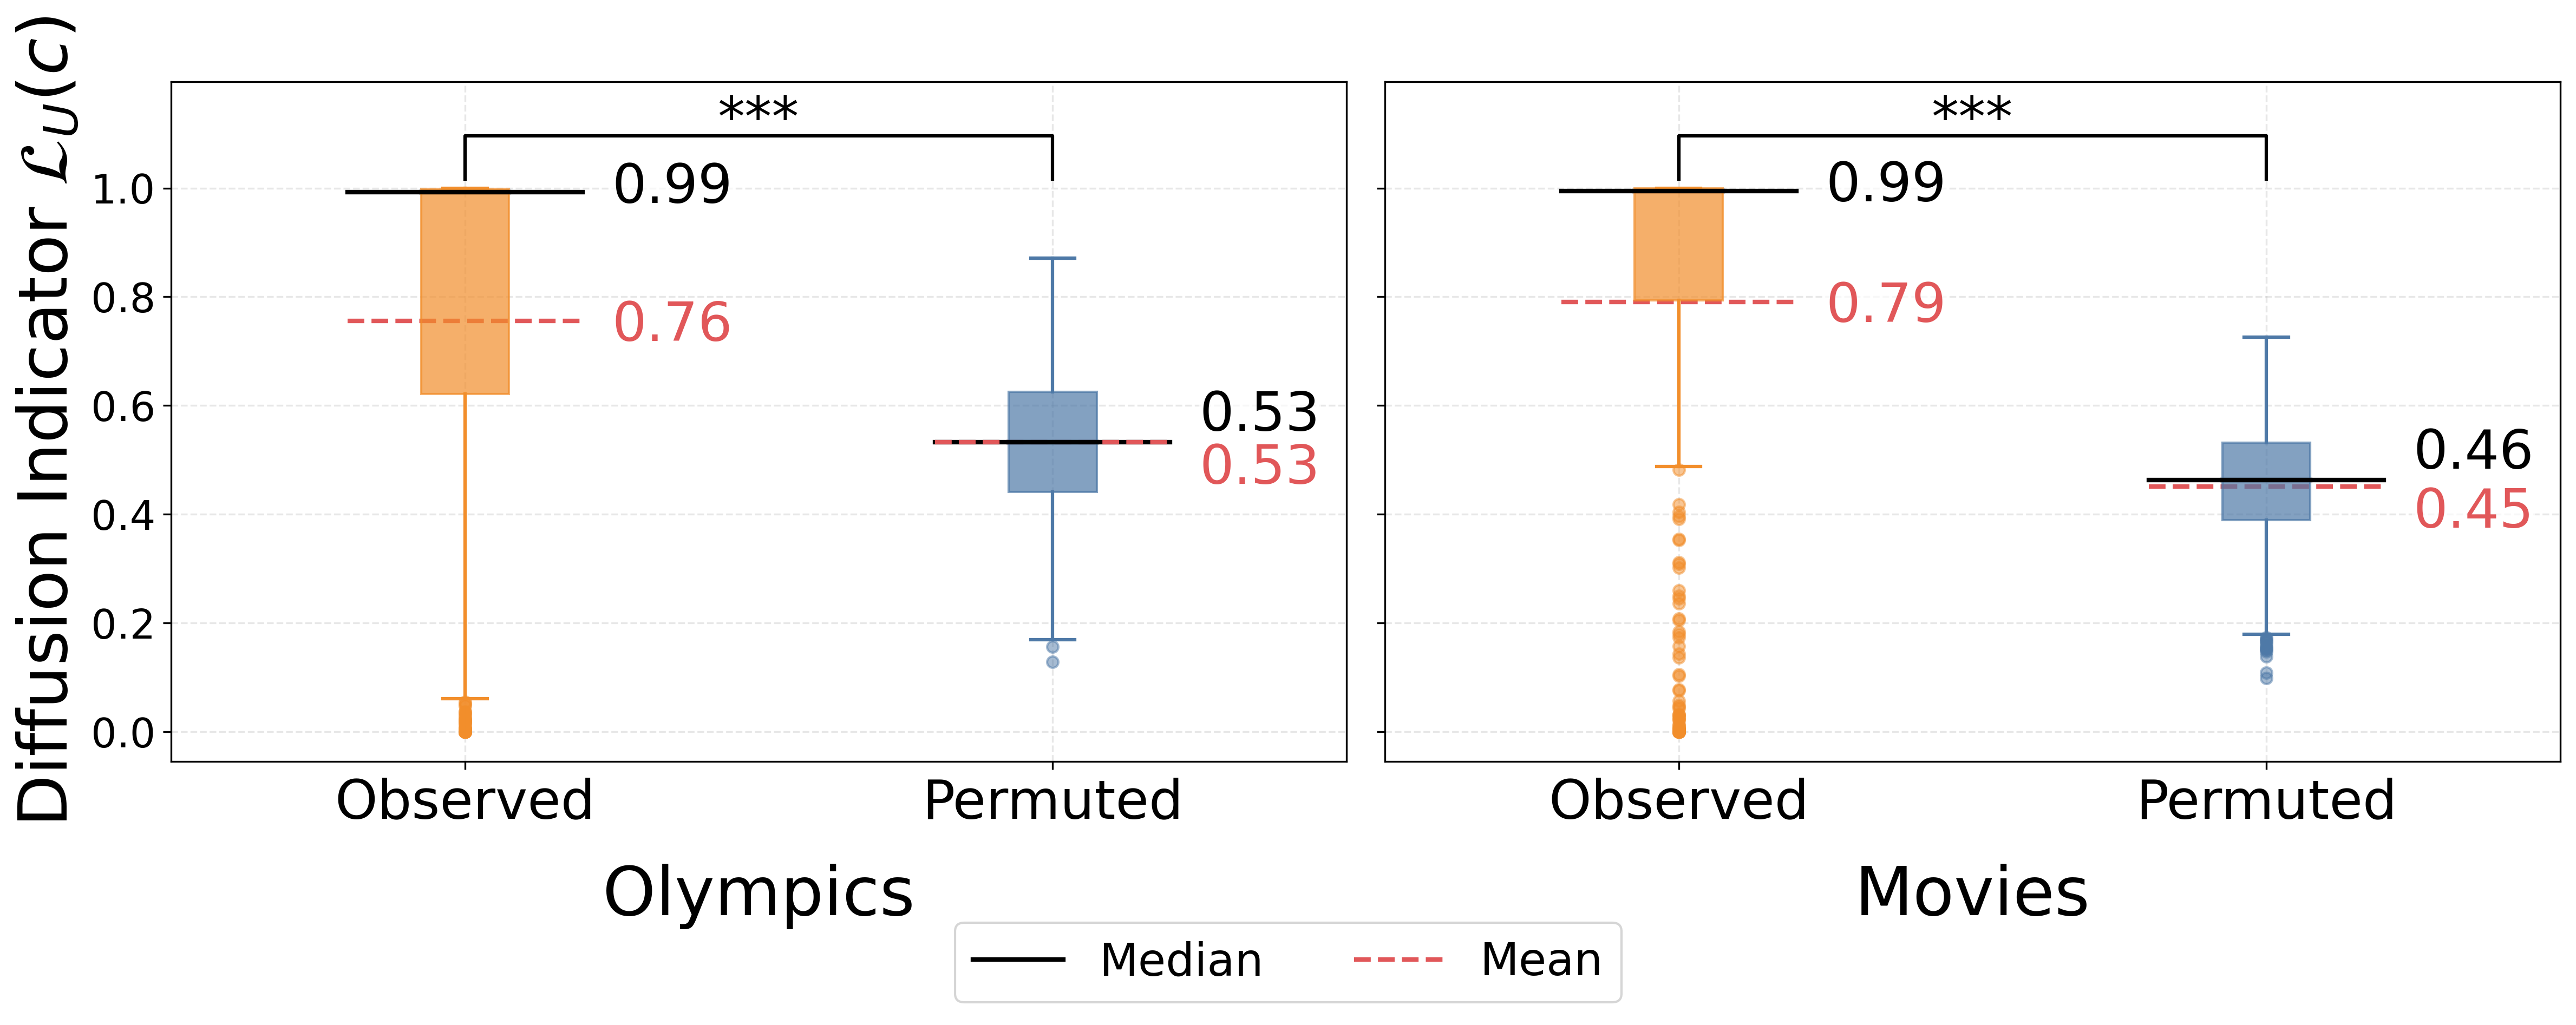

In [ ]:
import json   
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.lines import Line2D
from scipy.stats import mannwhitneyu

# Paths
result_path_1 = os.path.join(base_path, "Evaluation", "lc_max_strength.json")
result_path_2 = os.path.join(base_path, "Evaluation", "lc_max_strength.json")

# Load and analyze function
def load_and_analyze(result_path):
    with open(result_path, 'r') as f:
        results = json.load(f)
    correct_scores = []
    other_scores = []
    for tweet_id, groups in results.items():
        correct_score = groups['correct_group']
        others = [score for key, score in groups.items() if key != 'correct_group']
        correct_scores.append(correct_score)
        other_scores.extend(others)
    return correct_scores, other_scores

# Load data
correct_1, others_1 = load_and_analyze(result_path_1)
correct_2, others_2 = load_and_analyze(result_path_2)

# Set colors
colors = ['#f28e2b','#4e79a7']  # Orange, blue
mean_color = '#e15759'

# Subplot layout
fig, axs = plt.subplots(1, 2, figsize=(16, 6), dpi=300, sharey=True)

datasets = [
    (correct_1, others_1, "Olympics"),
    (correct_2, others_2, "Movies")
]

# Parameters for adjusting median and mean text positions for each bar separately
# Format: (horizontal offset, vertical offset ratio, relative to y_range)
# Example: first bar offset 0.25 right, 0.04 up; second bar offset 0.25 right, 0.07 up
median_text_offsets = [
    (0.25, -0.04),
    (0.25, 0.0),
]

mean_text_offsets = [
    (0.25, 0.04),
    (0.25, -0.0),
]

for i, (correct_scores, other_scores, title) in enumerate(datasets):
    ax = axs[i]
    data_groups = [correct_scores, other_scores]

    # Draw boxplot
    box = ax.boxplot(data_groups,
                     labels=['True Audiences', 'Non-audiences'],
                     patch_artist=True,
                     boxprops=dict(facecolor=colors[0], color=colors[0], alpha=0.7),
                     medianprops=dict(color='black', linewidth=2),
                     whiskerprops=dict(color=colors[0], linewidth=1.5),
                     capprops=dict(color=colors[0], linewidth=1.5),
                     flierprops=dict(marker='o', markersize=5,
                                     markerfacecolor=colors[0], alpha=0.5))

    # Set second boxplot to blue
    for j, color in enumerate(colors):
        box['boxes'][j].set(color=color, facecolor=color, alpha=0.7)
        box['medians'][j].set(color='black', linewidth=2)
        box['whiskers'][2 * j].set(color=color, linewidth=1.5)
        box['whiskers'][2 * j + 1].set(color=color, linewidth=1.5)
        box['caps'][2 * j].set(color=color, linewidth=1.5)
        box['caps'][2 * j + 1].set(color=color, linewidth=1.5)
        box['fliers'][j].set(markerfacecolor=color, markeredgecolor=color, alpha=0.5)

    # Draw median and mean lines with text, adjust positions separately
    for j, data in enumerate(data_groups):
        mean_val = np.mean(data)
        median_val = np.median(data)
        y_range = max(data) - min(data)

        # Get corresponding offset values
        median_x_offset, median_y_factor = median_text_offsets[j]
        mean_x_offset, mean_y_factor = mean_text_offsets[j]

        median_offset = median_y_factor * y_range
        mean_offset = abs(mean_y_factor) * y_range

        # Median line and annotation
        ax.plot([j + 0.8, j + 1.2], [median_val, median_val], color='black', linewidth=2)
        ax.text(j + 1 + median_x_offset, median_val + median_offset, f'{median_val:.2f}',
                ha='left', va='bottom', color='black', fontsize=24,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))

        # Mean line and annotation
        ax.plot([j + 0.8, j + 1.2], [mean_val, mean_val], color=mean_color, linestyle='--', linewidth=2)
        ax.text(j + 1 + mean_x_offset, mean_val + mean_y_factor * y_range, f'{mean_val:.2f}',
                ha='left', va='top', color=mean_color, fontsize=24,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))

    # Significance test (Mann-Whitney U)
    stat, p_val = mannwhitneyu(correct_scores, other_scores, alternative='two-sided')
    if p_val < 0.001:
        signif_label = '***'
    elif p_val < 0.01:
        signif_label = '**'
    elif p_val < 0.05:
        signif_label = '*'
    else:
        signif_label = 'n.s.'

    # Significance annotation line and asterisk
    y_max = max(max(correct_scores), max(other_scores))
    h = 0.08 * y_max  # Horizontal line height
    y1 = y_max + h
    y2 = y1 + h * 0.2  # Asterisk position slightly higher
    ax.plot([1, 1, 2, 2], [y_max + h * 0.2, y2, y2, y_max + h * 0.2], color='black', linewidth=1.5)
    ax.text(1.5, y2 -  0.02 * y_max, signif_label, ha='center', va='bottom', fontsize=24)

    ylim_upper = y2 + 0.1 * y_max  # Leave some margin
    ax.set_ylim(bottom=ax.get_ylim()[0], top=ylim_upper)
    
    # Axes and grid
    ax.set_xlabel(title, fontsize=30, labelpad=15)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Observed', 'Permuted'], fontsize=24)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.tick_params(axis='y', labelsize=18)
    if i == 0:
        ax.set_ylabel(r'Diffusion Indicator $\mathcal{L}_U(c)$', fontsize=30)

# Legend
legend_elements = [
    Line2D([0], [0], color='black', linewidth=2, label='Median'),
    Line2D([0], [0], color=mean_color, linestyle='--', linewidth=2, label='Mean')
]
fig.legend(handles=legend_elements, loc='lower center', fontsize=20, ncol=2)

# Layout adjustment and save
plt.tight_layout(rect=[0, 0.08, 1, 1])
output_path = os.path.join(base_path, "Evaluation", "lc_max_boxplot_two_datasets.png")
plt.savefig(output_path,
            dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


### Significance Testing

In [ ]:
import json
import numpy as np
from scipy import stats
from collections import defaultdict
import os

def check_assumptions(group1, group2):
    """Check data assumptions for t-test (normality and variance homogeneity)"""
    # Normality test (Shapiro-Wilk, recommended sample size <5000)
    _, p_normal_group1 = stats.shapiro(group1)
    _, p_normal_group2 = stats.shapiro(group2)
    
    # Variance homogeneity test (Levene, more robust than Bartlett)
    _, p_var = stats.levene(group1, group2)
    
    # Evaluate results
    assumptions = {
        'normality': {
            'group1': p_normal_group1,
            'group2': p_normal_group2,
            'is_normal': p_normal_group1 > 0.05 and p_normal_group2 > 0.05
        },
        'homogeneity': {
            'p_value': p_var,
            'is_equal_variance': p_var > 0.05
        }
    }
    return assumptions

def calculate_effect_size(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    mean1, mean2 = np.mean(group1), np.mean(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    d = (mean1 - mean2) / pooled_std
    
    # Effect size interpretation
    if abs(d) < 0.2:
        size = "negligible"
    elif abs(d) < 0.5:
        size = "small"
    elif abs(d) < 0.8:
        size = "medium"
    else:
        size = "large"
    
    return d, size

def perform_significance_testing(result_path):
    """
    Independent module for performing significance testing (enhanced version)
    Parameters:
        result_path: Path to result file (string)
    Returns:
        Significance test results (including detailed classification and effect size)
    """
    # Load results
    with open(result_path, 'r') as f:
        results = json.load(f)
    
    analysis = {
        'correct_scores': [],
        'other_scores': [],
        'stats_test': {},
        'effect_size': {}
    }
    
    for tweet_id, groups in results.items():
        correct_score = groups['correct_group']
        other_scores = [score for key, score in groups.items() if key != 'correct_group']
        
        analysis['correct_scores'].append(correct_score)
        analysis['other_scores'].extend(other_scores)
    
    # Check data assumptions
    analysis['assumptions'] = check_assumptions(
        analysis['correct_scores'],
        analysis['other_scores']
    )
    
    # Perform independent t-test (Welch's t-test)
    t_test = stats.ttest_ind(
        analysis['correct_scores'], 
        analysis['other_scores'],
        equal_var=False
    )
    
    # Calculate effect size
    cohen_d, effect_size = calculate_effect_size(
        analysis['correct_scores'],
        analysis['other_scores']
    )
    
    analysis['stats_test']['independent_ttest'] = {
        'statistic': t_test.statistic,
        'p_value': t_test.pvalue,
        'mean_diff': np.mean(analysis['correct_scores']) - np.mean(analysis['other_scores']),
        'cohen_d': cohen_d,
        'effect_size': effect_size
    }
    
    # Mann-Whitney U test
    u_test = stats.mannwhitneyu(
        analysis['correct_scores'], 
        analysis['other_scores'],
        alternative='greater'
    )
    
    # Calculate non-parametric effect size (rank biserial correlation)
    n1, n2 = len(analysis['correct_scores']), len(analysis['other_scores'])
    rbc = 1 - (2 * u_test.statistic) / (n1 * n2)  # Rank biserial correlation
    
    analysis['stats_test']['mannwhitneyu'] = {
        'statistic': u_test.statistic,
        'p_value': u_test.pvalue,
        'rbc': rbc
    }
    
    return analysis

def interpret_p_value(p_value):
    """Detailed interpretation of p-value significance level"""
    if p_value < 0.001:
        symbol = "***"
        interpretation = "highly significant (p < 0.001)"
    elif p_value < 0.01:
        symbol = "**"
        interpretation = "very significant (p < 0.01)"
    elif p_value < 0.05:
        symbol = "*"
        interpretation = "significant (p < 0.05)"
    elif p_value < 0.1:
        symbol = "."
        interpretation = "marginally significant (p < 0.1)"
    else:
        symbol = "n.s."
        interpretation = "not significant (p ≥ 0.1)"
    
    return symbol, interpretation


def print_significance_results(analysis):
    """
    Print enhanced significance test results
    Parameters:
        analysis: Return result from perform_significance_testing() function
    """
    print(f"\n{'='*40}")
    print(f"===== Detailed Significance Test Report =====")
    print(f"{'='*40}")
    
    # Basic data information
    print(f"\n[Basic Data]")
    print(f"Correct group sample size: {len(analysis['correct_scores'])}")
    print(f"Other group sample size: {len(analysis['other_scores'])}")
    print(f"Correct group mean: {np.mean(analysis['correct_scores']):.4f} ± {np.std(analysis['correct_scores'], ddof=1):.4f}")
    print(f"Other group mean: {np.mean(analysis['other_scores']):.4f} ± {np.std(analysis['other_scores'], ddof=1):.4f}")
    
    # Assumption test results
    print(f"\n[Assumption Tests]")
    print(f"Normality test (Shapiro-Wilk):")
    print(f"  Correct group p = {analysis['assumptions']['normality']['group1']:.4f} | "
          f"{'satisfied' if analysis['assumptions']['normality']['group1'] > 0.05 else 'not satisfied'} normality")
    print(f"  Other group p = {analysis['assumptions']['normality']['group2']:.4f} | "
          f"{'satisfied' if analysis['assumptions']['normality']['group2'] > 0.05 else 'not satisfied'} normality")
    print(f"Variance homogeneity test (Levene): p = {analysis['assumptions']['homogeneity']['p_value']:.4f} | "
          f"{'satisfied' if analysis['assumptions']['homogeneity']['is_equal_variance'] else 'not satisfied'} equal variance")
    
    # Test method recommendation
    print(f"\n[Test Recommendation]")
    if analysis['assumptions']['normality']['is_normal']:
        print("✓ Data satisfies normality assumption, t-test results are reliable")
    else:
        print("⚠ Data does not satisfy normality assumption, recommend prioritizing Mann-Whitney U test")
        
    # Independent samples t-test results
    t_test = analysis['stats_test']['independent_ttest']
    p_symbol, p_interp = interpret_p_value(t_test['p_value'])
    
    print(f"\n[Independent Samples t-test]")
    print(f"Mean difference: {t_test['mean_diff']:.4f} (correct group - other group)")
    print(f"t({len(analysis['correct_scores'])+len(analysis['other_scores'])-2}) = {t_test['statistic']:.3f}")
    print(f"p-value: {t_test['p_value']:.5f} {p_symbol} ({p_interp})")
    print(f"Cohen's d effect size: {t_test['cohen_d']:.3f} ({t_test['effect_size']} effect)")
    
    # Mann-Whitney U test results
    u_test = analysis['stats_test']['mannwhitneyu']
    p_symbol, p_interp = interpret_p_value(u_test['p_value'])
    
    print(f"\n[Mann-Whitney U Test]")
    print(f"U statistic: {u_test['statistic']:.0f}")
    print(f"p-value: {u_test['p_value']:.5f} {p_symbol} ({p_interp})")
    print(f"Rank biserial correlation (rbc): {u_test['rbc']:.3f}")
    
    # Comprehensive interpretation
    print(f"\n[Comprehensive Conclusion]")
    if t_test['p_value'] < 0.05:
        direction = "higher than" if t_test['mean_diff'] > 0 else "lower than"
        print(f"• t-test indicates correct group pijc scores are significantly {direction} other group")
        print(f"  Effect size Cohen's d = {t_test['cohen_d']:.2f} ({t_test['effect_size']} effect)")
    else:
        print("• t-test found no significant difference")
    
    if u_test['p_value'] < 0.05:
        print("• Non-parametric test confirms significant distribution difference between groups")
    else:
        print("• Non-parametric test found no significant distribution difference")
    
    # Add horizontal line separator
    print(f"\n{'='*40}")

# Usage example
if __name__ == "__main__":    
    result_path = os.path.join(base_path, "Evaluation", "lc_max_strength.json")
    
    # Perform analysis
    test_results = perform_significance_testing(result_path)
    
    # Print report
    print_significance_results(test_results)


===== Detailed Significance Test Report =====

[Basic Data]
Correct group sample size: 500
Other group sample size: 500
Correct group mean: 0.7901 ± 0.3647
Other group mean: 0.4514 ± 0.1208

[Assumption Tests]
Normality test (Shapiro-Wilk):
  Correct group p = 0.0000 | not satisfied normality
  Other group p = 0.0000 | not satisfied normality
Variance homogeneity test (Levene): p = 0.0000 | not satisfied equal variance

[Test Recommendation]
⚠ Data does not satisfy normality assumption, recommend prioritizing Mann-Whitney U test

[Independent Samples t-test]
Mean difference: 0.3387 (correct group - other group)
t(998) = 19.713
p-value: 0.00000 *** (highly significant (p < 0.001))
Cohen's d effect size: 1.247 (large effect)

[Mann-Whitney U Test]
U statistic: 202182
p-value: 0.00000 *** (highly significant (p < 0.001))
Rank biserial correlation (rbc): -0.617

[Comprehensive Conclusion]
• t-test indicates correct group pijc scores are significantly higher than other group
  Effect size 